# Autograd 

In [1]:
import torch, torchvision

In [2]:
model = torchvision.models.resnet18(pretrained=True)
data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\aleks/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [3]:
prediction = model(data) # forward pass

c:\users\aleks\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [4]:
loss = (prediction - labels).sum()
loss.backward() # backward pass

In [5]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [6]:
optim.step() #gradient descent

## Differentiation in Autograd 

In [7]:
import torch

In [8]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

In [9]:
Q = 3*a**3 - b**2

In [10]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

In [11]:
# check if collected gradients are correct
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


## Exclusion from the DAG

In [12]:
x = torch.rand(5, 5)
y = torch.rand(5, 5)
z = torch.rand((5, 5), requires_grad=True)

In [13]:
a = x + y
print(f"Does `a` require gradients? : {a.requires_grad}")

Does `a` require gradients? : False


In [14]:
b = x + z
print(f"Does `b` require gradients?: {b.requires_grad}")

Does `b` require gradients?: True


In [15]:
from torch import nn, optim

In [16]:
model = torchvision.models.resnet18(pretrained=True)

In [17]:
# Freeze all the parameters in the network
for param in model.parameters():
    param.requires_grad = False

In [18]:
model.fc = nn.Linear(512, 10)

In [19]:
# Optimize only the classifier
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

# Neural Networks 

## Define the network 

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [21]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [22]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [23]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


In [24]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.0569, -0.0004, -0.1111,  0.0595, -0.0630, -0.0390, -0.0687,  0.0119,
         -0.0383, -0.0240]], grad_fn=<AddmmBackward>)


In [25]:
net.zero_grad()
out.backward(torch.randn(1, 10))

## Loss Function 

In [26]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

In [27]:
loss = criterion(output, target)
print(loss)

tensor(0.9590, grad_fn=<MseLossBackward>)


In [28]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

## Backprop 

In [29]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])


In [30]:
loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad after backward
tensor([ 0.0045, -0.0034,  0.0034, -0.0020,  0.0124,  0.0003])


## Update the weights 

In [31]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [32]:
import torch.optim as optim

In [33]:
# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [34]:
# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

# Training a Classifier 

In [35]:
import torch
import torchvision
import torchvision.transforms as transforms

## 1. Load and normalize CIFAR10 

In [36]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [37]:
batch_size = 4

In [38]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [39]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [40]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [41]:
import matplotlib.pyplot as plt
import numpy as np

In [42]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [43]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

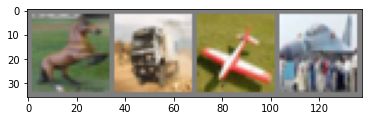

In [44]:
# show images
imshow(torchvision.utils.make_grid(images))

In [45]:
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

horse truck plane plane


## 2. Define a Convolutional Neural Network 

In [46]:
import torch.nn as nn
import torch.nn.functional as F

In [47]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [48]:
net = Net()

## 3. Define a Loss function and optimizer 

In [49]:
import torch.optim as optim

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network 

In [51]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.294
[1,  4000] loss: 2.081
[1,  6000] loss: 1.821
[1,  8000] loss: 1.676
[1, 10000] loss: 1.582
[1, 12000] loss: 1.538
[2,  2000] loss: 1.440
[2,  4000] loss: 1.414
[2,  6000] loss: 1.373
[2,  8000] loss: 1.363
[2, 10000] loss: 1.339
[2, 12000] loss: 1.299
Finished Training


In [53]:
PATH = './models/cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 5. Test the network on the test data 

In [54]:
dataiter = iter(testloader)
images, labels = dataiter.next()

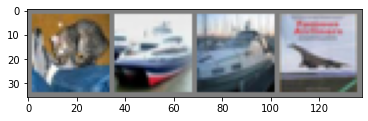

GroundTruth:    cat  ship  ship plane


In [55]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [56]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [57]:
outputs = net(images)

In [58]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship  ship


In [59]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [60]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

In [61]:
# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

In [62]:
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 58.0 %
Accuracy for class car   is: 69.5 %
Accuracy for class bird  is: 38.2 %
Accuracy for class cat   is: 21.0 %
Accuracy for class deer  is: 40.8 %
Accuracy for class dog   is: 59.3 %
Accuracy for class frog  is: 59.5 %
Accuracy for class horse is: 72.6 %
Accuracy for class ship  is: 68.1 %
Accuracy for class truck is: 62.7 %


## Training on GPU 

In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [64]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [65]:
inputs, labels = data[0].to(device), data[1].to(device)